# Experimentation with langchain

## 1. Retrieve data and build documents

In [1]:
import json
from tqdm import tqdm
from langchain_core.documents import Document

# Raw, parsed data
with open("../../sra-rag-data/sra-data.json") as f:
    data = json.load(f)

# Documents for ingestion
documents = []
for entry in tqdm(data, desc="Building documents"):
    doc = Document(
        page_content=entry["text"],
        metadata=entry["metadata"],
        id=entry["metadata"].pop("sra_id"),
    )
    documents.append(doc)

print(f"Built {len(documents)} documents.")

Building documents: 100%|██████████| 548/548 [00:00<00:00, 175202.27it/s]

Built 548 documents.


## 2. Embedding database

## 2.1 Initialize

In [2]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

# Embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", show_progress=True)

# Vector store initialization
vector_store = Chroma(
    collection_name="SRA-RAG-langchain",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",
)

## 2.2 Compute and save embeddings 

In [3]:
# Compute embeddings and add to vector store, can take a while...
vector_store.add_documents(documents=documents)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

['SRA2196416',
 'SRA1983141',
 'SRA1957736',
 'SRA2118646',
 'SRA1930417',
 'SRA2210196',
 'SRA2047875',
 'SRA1982315',
 'SRA2109888',
 'SRA1957794',
 'SRA2208763',
 'SRA2135293',
 'SRA1689764',
 'SRA2178327',
 'ERA30836745',
 'SRA2152740',
 'SRA1951563',
 'SRA1969896',
 'SRA2206512',
 'SRA1960373',
 'SRA1931618',
 'SRA2077944',
 'SRA1062347',
 'SRA2210342',
 'SRA1946551',
 'SRA2081267',
 'SRA1861740',
 'SRA1937681',
 'SRA1932320',
 'SRA1473851',
 'SRA2177452',
 'SRA1754638',
 'SRA1687377',
 'SRA1504907',
 'SRA1701239',
 'SRA1750092',
 'SRA1239013',
 'SRA1611394',
 'SRA1800483',
 'SRA1701234',
 'ERA31115822',
 'SRA1488430',
 'SRA2153479',
 'SRA1960788',
 'SRA1439928',
 'SRA1932316',
 'SRA2210307',
 'SRA2115990',
 'SRA1947084',
 'SRA2160803',
 'ERA33752657',
 'SRA1532995',
 'SRA2060953',
 'SRA2156393',
 'SRA1056769',
 'SRA1974614',
 'SRA1502808',
 'SRA1258575',
 'SRA2062342',
 'SRA1689761',
 'SRA2160392',
 'SRA1839837',
 'SRA1961515',
 'SRA2113585',
 'SRA1992978',
 'SRA2195141',
 'SRA20

# 3. RAG main logic

## 3.1. Select a LLM model for text generation

In [4]:
# Option 1: Local LLM, can be slow if not on GPU

# from transformers import pipeline
# from langchain_huggingface import HuggingFacePipeline

# generator = pipeline(
#     "text-generation",
#     model="microsoft/Phi-3-mini-4k-instruct",
#     device_map="auto",
# )

# llm = HuggingFacePipeline(pipeline=generator)

In [5]:
# Option 2: GoogleGenAI LLM, requires API key
# Can run into rate limits

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

## 3.2. State, retrieval and generation functions

In [6]:

from langchain import hub
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# Get RAG prompt
prompt = hub.pull("rlm/rag-prompt")

# Define State type
class State(TypedDict):
    question: str
    context: List[Document] = []
    answer: str = ""

def summary(s: State) -> str:
    print('\n'.join([
        f"question={s.get('question')}",
        f"context=[{', '.join(doc.id for doc in s.get('context', []))}]"
        f"answer={s.get('answer')}",
    ]))

# Retrieve function
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return dict(context=retrieved_docs)

# Response
def generate(state: State):
    if not state['context']:
        return {"answer": "No relevant documents found."}
    docs_content = "\n\n".join(doc.page_content for doc in state['context'])
    messages = prompt.invoke({"question": state['question'], "context": docs_content})
    response = llm.invoke(messages)
    return dict(answer=response.content)

## 3.3.1 With LangChain

In [7]:
question = "list lupus studies"
state = State()
state.update(dict(question=question))
state.update(retrieve(state))
state.update(generate(state))

summary(state)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

question=list lupus studies
context=[SRA2159709, SRA1918369, SRA1967084, SRA1184880]answer=The following studies are related to lupus:

1.  DNase I alleviates renal inflammatory injury in MRL/lpr mice by inhibiting NETs formation.
2.  Gene expression profile at single cell level of lung from TRAF5 knockout mouse with Systemic Lupus Erythematosus-associated Pulmonary Arterial Hypertension (SLE-PAH).


## 3.3.2. With LangGraph

Added benefit of having a stateful app

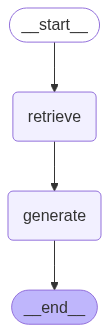

In [8]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
result = graph.invoke({"question": input()})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Context: [Document(id='SRA2127544', metadata={'srp_id': 'SRP584603', 'bioproject': 'PRJNA1261824', 'species': 'mus musculus(n=4)'}, page_content='title: GEO accession GSE296856 is currently private and is scheduled to be released on May 12, 2027.\nstudy_type: Transcriptome Analysis(N=1)\nabstract: If GEO accession GSE296856 has been cited in a publication, please notify us at geo@ncbi.nlm.nih.gov to initiate the public release of associated data.(N=1)\ntitle: amygdala, female, batch 2|amygdala, female, batch 1|amygdala, male, batch 2|amygdala, male, batch 3\nspecies: Mus musculus(N=4)\nsource_name: neural tissue(N=4)\ntissue: neural tissue(N=4)\ncell line: telencephalon(N=4)\ncell type: glia, neurons(N=4)\ngenotype: WT(N=4)\ntreatment: no treatment(N=4)\nbatch: 2(N=2)|1(N=1)|3(N=1)\ngeo_loc_name: missing(N=4)\ncollection_date: missing(N=4)'), Document(id='SRA1983141', metadata={'species': 'homo sapiens(n=4)', 'bioproject': 'PRJNA1167329', 'srp_id': 'SRP535818'}, page_content='title: Un